In [1]:
import torch, torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
image_folder = "/mnt/AdityaAshokBarot/afhq/train"

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
BATCH_SIZE = 128

dataset = ImageFolder(image_folder, transform = transform)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Building the model!!!

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels, hidden_channels, latent_dim):
        
        super(Encoder, self).__init__()
        
        self.convblock = nn.Sequential(nn.Conv2d(in_channels, hidden_channels, 4, 2, 1),
                                       nn.Conv2d(hidden_channels, hidden_channels, 4, 2, 1))
        
        self.residual1 = nn.Conv2d(hidden_channels, hidden_channels, 3, 1, 1)
        self.residual2 = nn.Conv2d(hidden_channels, hidden_channels, 1, 1, 0)
        
        self.projection = nn.Conv2d(hidden_channels, latent_dim, 1, 1, 0)
        
    def forward(self, x):
        
        x = self.convblock(x)
        x = F.relu(x)
        x = x + self.residual1(x)
        x = F.relu(x)
        x = x + self.residual2(x)
        
        ze_x = self.projection(x)
        
        return ze_x 
class VQEmbeddings(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, beta):
        
        super(VQEmbeddings, self).__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta
        
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        
    def forward(self, inputs):
        #first permute the inputs from BCHW -> BHWC because we will be flattening around the channels, i.e the channels of the encoder output ze_x will act as the embedding_dimension
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        inputs_shape = inputs.shape
        
        flattened_inputs = inputs.view(-1, self.embedding_dim)
        
        #calculating the distances
        
        distances = torch.sum(flattened_inputs**2, dim = 1, keepdim = True) + torch.sum(self.embeddings.weight ** 2, dim = 1) - 2 * torch.matmul(flattened_inputs, self.embeddings.weight.t())   #gives the matrix for the distances between each input vector of latent dim  and the each embedding vector of latent dim. shape of matrix --> B*H*W x num_embeddings
                                                                                                                                                               #basically is a very clean idea of avoiding the brute force in which I take one vector from the input and calculate the distances between that vector and each embedding vector
                                                                                                                                                               #the distance is simply the l2-norm distance between 2 vectors => ||a-b||^2 = ||a||^2 + ||b||^2 - 2*a.b
        K = torch.argmin(distances, dim = 1).unsqueeze(1)  #indices corresponding to the minimum distance for each input vector
        
        q_onehot = torch.zeros_like(distances, device = flattened_inputs.device)
        q_onehot.scatter_(1, K, 1)
        
        zq_x = torch.matmul(q_onehot, self.embeddings.weight).view(inputs_shape)  #another clever and clean way to select the embedding vector corresponding to the indices in K!!!, instead of going brute force way!
        
        e_latent_loss = F.mse_loss(zq_x, inputs.detach())
        commitment_loss = F.mse_loss(zq_x.detach(), inputs)
        
        loss = e_latent_loss + self.beta * commitment_loss
        
        zq_x = zq_x + (zq_x - inputs).detach()
        avg_probs = torch.mean(q_onehot, dim = 0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        
    
        
        return zq_x.permute(0, 3, 1, 2), e_latent_loss, perplexity, self.beta * commitment_loss
class Decoder(nn.Module):
    
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.in_projection = nn.Conv2d(in_channels, hidden_channels, 1, 1, 0)
        
        self.residualconv1 = nn.Conv2d(hidden_channels, hidden_channels, 3, 1, 1)
        self.residualconv2 = nn.Conv2d(hidden_channels, hidden_channels, 3, 1, 1)
        
        self.strided_T_conv1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, 4, 2, 1)
        self.strided_T_conv2 = nn.ConvTranspose2d(hidden_channels, out_channels, 4, 2, 1)
        
    def forward(self, z):
        
        z = self.in_projection(z)
        
        z = z + self.residualconv1(z)
        
        z = F.relu(z)
        
        z = z + self.residualconv2(z)
        z = F.relu(z)
        
        z = self.strided_T_conv1(z)
        x_cap = self.strided_T_conv2(z)
        
        return x_cap

In [7]:
class VQVAE(nn.Module):
    
    def __init__(self, in_channels, hidden_channels, latent_dim, num_embeddings, embedding_dim, beta, out_channels):
        super(VQVAE, self).__init__()
        
        self.encoder = Encoder(in_channels, hidden_channels, latent_dim)
        self.vector_quantizer = VQEmbeddings(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder(latent_dim, hidden_channels, out_channels)
        
    def forward(self, x):
        
        zex = self.encoder(x)
        zqx, codebook_loss, perplexity, commitment_loss = self.vector_quantizer(zex)
        x_cap = self.decoder(zqx)
        
        return x_cap, codebook_loss, perplexity, commitment_loss 
    

In [8]:
img = torch.randn(2, 3, 32, 32).to(device)

vqvae = VQVAE(3, 512, 64, 512, 64, 0.25, 3).to(device)

x_cap, codebook_loss, perplexity, commitment_loss = vqvae(img)
x_cap.device

device(type='cuda', index=0)

Training The Model!!!

In [9]:
#Inititalize the model
IN_CHANNELS = 3
OUT_CHANNELS = 3
HIDDEN_CHANNELS = 512
LATENT_DIM = 64
NUM_EMBEDDINGS = 512
EMBEDDING_DIM = 64
BETA = 0.25

VQ_VAE = VQVAE(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM, NUM_EMBEDDINGS, EMBEDDING_DIM, BETA, OUT_CHANNELS).to(device)


In [10]:
encoder = Encoder(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM).to(device)
vq = VQEmbeddings(NUM_EMBEDDINGS, EMBEDDING_DIM, BETA).to(device)
decoder = Decoder(LATENT_DIM, HIDDEN_CHANNELS, OUT_CHANNELS).to(device)
       

In [12]:
import torch.optim as optim

optimizer = optim.Adam(VQ_VAE.parameters(), lr = 0.0002)

criterion  = nn.MSELoss()
VQ_VAE.train()
encoder.train() ,vq.train(), decoder.train()

(Encoder(
   (convblock): Sequential(
     (0): Conv2d(3, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   )
   (residual1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (residual2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
   (projection): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
 ),
 VQEmbeddings(
   (embeddings): Embedding(512, 64)
 ),
 Decoder(
   (in_projection): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1))
   (residualconv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (residualconv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (strided_T_conv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (strided_T_conv2): ConvTranspose2d(512, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 ))

In [13]:
EPOCHS = 5

for epoch in range(EPOCHS):
    
    for batch_idx, (images, _) in enumerate(dataloader):
        
       images = images.to(device)
       optimizer.zero_grad()
       
       ze_x = encoder(images)
       zq_x, codebook_loss, perplexity, commitment_loss = vq(ze_x)
       x_cap = decoder(zq_x)
       mse_loss = criterion(x_cap, images)
       loss = mse_loss + codebook_loss + BETA*commitment_loss
       loss.backward(retain_graph = True)
       optimizer.step()
       
   #  if batch_idx % 50 == 0:
    print(f"EPOCH:{epoch + 1}, BATCH_INDEX:{batch_idx + 1}, RECONSTRUCTION_LOSS = {mse_loss}, CODEBOOK_LOSS:{codebook_loss}, COMMITMENT_LOSS:{commitment_loss}, TOTAL_LOSS:{loss}, PERPLEXITY:{perplexity} ")

EPOCH:1, BATCH_INDEX:115, RECONSTRUCTION_LOSS = 0.2259926050901413, CODEBOOK_LOSS:0.0067032817751169205, COMMITMENT_LOSS:0.0016758204437792301, TOTAL_LOSS:0.23311485350131989, PERPLEXITY:21.846874237060547 
EPOCH:2, BATCH_INDEX:115, RECONSTRUCTION_LOSS = 0.24974094331264496, CODEBOOK_LOSS:0.007193387486040592, COMMITMENT_LOSS:0.001798346871510148, TOTAL_LOSS:0.25738394260406494, PERPLEXITY:20.799436569213867 
EPOCH:3, BATCH_INDEX:115, RECONSTRUCTION_LOSS = 0.24579627811908722, CODEBOOK_LOSS:0.007237672805786133, COMMITMENT_LOSS:0.0018094182014465332, TOTAL_LOSS:0.2534862756729126, PERPLEXITY:22.155101776123047 
EPOCH:4, BATCH_INDEX:115, RECONSTRUCTION_LOSS = 0.24206021428108215, CODEBOOK_LOSS:0.007321751676499844, COMMITMENT_LOSS:0.001830437919124961, TOTAL_LOSS:0.24983957409858704, PERPLEXITY:20.8060302734375 
EPOCH:5, BATCH_INDEX:115, RECONSTRUCTION_LOSS = 0.22956912219524384, CODEBOOK_LOSS:0.006770983338356018, COMMITMENT_LOSS:0.0016927458345890045, TOTAL_LOSS:0.23676329851150513, P

EVALUATING THE MODEL!!!

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def draw_sample_images(x, postfix):
    
    plt.figure(figsize = (8, 8 ))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding = 2, normalize = True), (1, 2, 0)))

In [17]:
# VQ_VAE.eval()
encoder.eval()
vq.eval()
decoder.eval()

with torch.no_grad():
    
    for batch_idx, (image, _) in enumerate(dataloader):
        
        image = image.to(device)
        # x_cap, codebook_loss, perplexity, commitment_loss = VQ_VAE(image)
        ze_x = encoder(image)
        zq_x, codebook_loss, perplexity, commitment_loss = vq(ze_x)
        x_cap = decoder(zq_x)

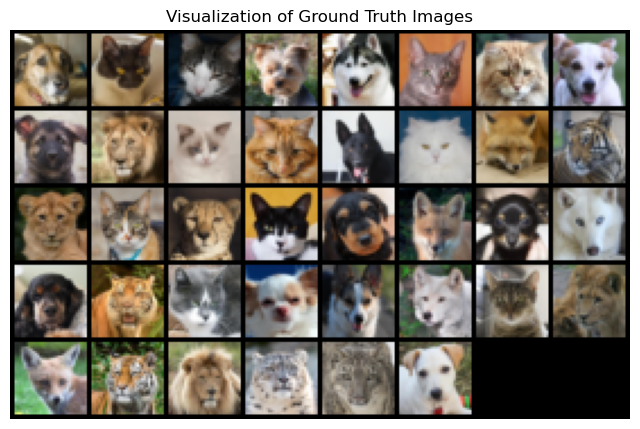

In [18]:
draw_sample_images(image[:BATCH_SIZE // 2], "Ground Truth Images")

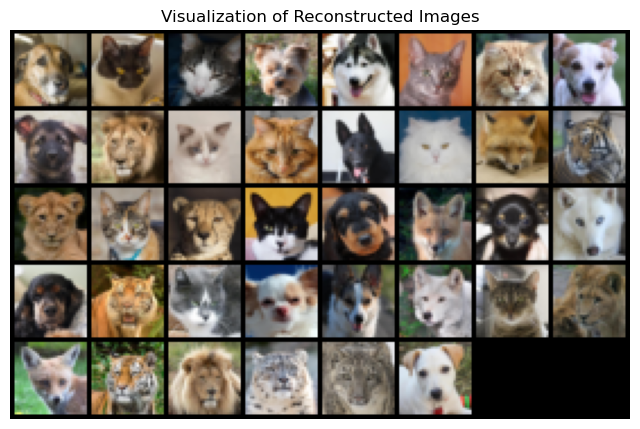

In [19]:
draw_sample_images(image[:BATCH_SIZE // 2], "Reconstructed Images")